# start

from mdl0331_4__xgb_5e5;

remove twttp freq feature

In [1]:
PRFX='mdl0331_5_2'

trntmstmp=1584412344
valtmstmp=1585761578

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)

SEED=101

valsz = int(10)
trnsz = int(1e6)

train_total=int(1.5e8)
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

train_total 150,000,000, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-01 17:19:38']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
print(tgt2col)
ntgts=len(tgts)

{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
%%time
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz,nrows=trnsz)

CPU times: user 6.95 s, sys: 876 ms, total: 7.83 s
Wall time: 7.83 s


In [4]:
twttyps=['TopLevel','Retweet','Quote']

lang2freq=dict(dftrn.lang.value_counts()/len(dftrn))
langs2feat=[k for k,v in lang2freq.items() if v>=0.01]
len(langs2feat)

11

In [5]:
def prp_tm(df, col):
    dt=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=dt.dt.dayofweek
    df[col+'_hour']=dt.dt.hour

def prpdf(df,istrn=True):
    tags = ['hshtgs','media','links','domns',]
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('')
        lst=df[tag].apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=lst.apply(len)

    lst=df['media'].apply(lambda x: x.split('\t') if len(x) else [])
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = lst.apply(lambda x: x.count(m))
    
    df[f'n_{tag}']=lst.apply(len)

    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    prp_tm(df, 'tm')
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs2feat:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    
    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded = cnt_encded/len(df)
    cnt_encded.columns = [f'{col}_freq' for col in ce_features]
    df = pd.concat([df,cnt_encded],1)

    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp','lang', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id','u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks','hshtgs','media','links','domns','twttyp','lang', 
                                       'tm','u1_create_tm','u2_create_tm','u1u2','u1id', ])        
    return df    

In [6]:
%%time
dftrn = prpdf(dftrn)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 23.4 s, sys: 4.62 s, total: 28 s
Wall time: 28 s


In [7]:
cols_feat=[o for o in dftrn.columns if o not in cols_tgt]
cols_feat

['u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_follower_cnt',
 'u2_following_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_links',
 'n_links',
 'has_domns',
 'n_domns',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'len_toks',
 'tm_dayofweek',
 'tm_hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'tmleft_twt',
 'tmleft_u1',
 'tmleft_u2',
 'twttyp_TopLevel',
 'twttyp_Retweet',
 'twttyp_Quote',
 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
 'lang_22C448FF81263D4BAF2A176145EE9EAD',
 'lang_06D61DCBBE938971E1EA0C38BD9B5446',
 'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
 'lang_B9175601E87101A984A50F8A62A1C374',
 'lang_4DC22C3F31C5C43721E6B5815A595ED6',
 'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
 'lang_125C57F4FA6D4E110983FB11B52EFD4E',
 'lang_022EC308651FACB02794A8147AEE1B78',
 'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
 'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
 'lang_freq',
 'u1id_freq',
 'u2id_freq',
 'u1u2_freq',
 'twtid_freq']

In [8]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)

CPU times: user 8.42 ms, sys: 72 µs, total: 8.49 ms
Wall time: 7.44 ms


In [9]:
%%time
dfval = prpdf(dfval)

CPU times: user 76.9 ms, sys: 4.86 ms, total: 81.8 ms
Wall time: 72.8 ms


# model

In [10]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}
tgt2res = {}


In [11]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=10000, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=100,
                    early_stopping_rounds=100)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl


def traintgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    
    msk_vl=np.random.rand(len(dftrn))<0.15
    idxvl=np.where( msk_vl)[0]
    idxtr=np.where(~msk_vl)[0]
    ytr=dftrn.iloc[idxtr][tgtcol]
    yvl=dftrn.iloc[idxvl][tgtcol]
    dtr = xgb.DMatrix(dftrn.iloc[idxtr][cols_feat], label=ytr, feature_names=cols_feat)
    dvl = xgb.DMatrix(dftrn.iloc[idxvl][cols_feat], label=yvl, feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    return {
    'bst':bst,
    'evals_result':evals_result,
    'ytr':ytr,
    'yvl':yvl,
    'prdtr':prdtr,
    'prdvl':prdvl,
    }
    

In [12]:
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    tmstart=time.time()
    tgt2res[tgt]=traintgt(tgt)
    print('Ran for',int((time.time()-tmstart)/60),'mins')

2020-03-31 22:29:27 Retweet ********************************************************************************
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.26859	train-logloss:0.53296	eval-aucpr:0.26198	eval-logloss:0.53289
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[100]	train-aucpr:0.39126	train-logloss:0.29272	eval-aucpr:0.35036	eval-logloss:0.30134
[200]	train-aucpr:0.42542	train-logloss:0.28470	eval-aucpr:0.35349	eval-logloss:0.30056
[300]	train-aucpr:0.45507	train-logloss:0.27766	eval-aucpr:0.35425	eval-logloss:0.30050
[400]	train-aucpr:0.48500	train-logloss:0.27052	eval-aucpr:0.35480	eval-logloss:0.30063
Stopping. Best iteration:
[342]	train-aucpr:0.46758	train-logloss:0.27473	eval-aucpr:0.35492	eval-logloss:0.30040

Ran for 4 mins
2020-03-31 22:34:27 Reply *************************************************************

# analyze

## tr vl

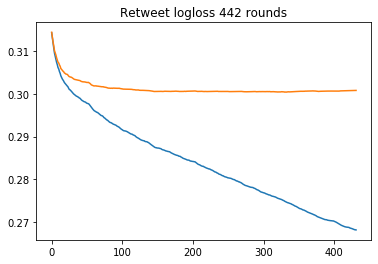

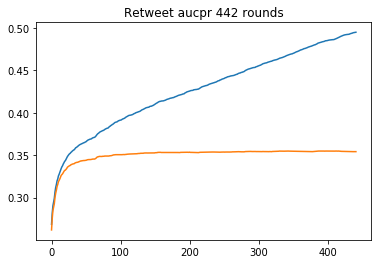

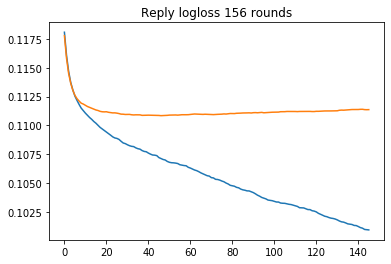

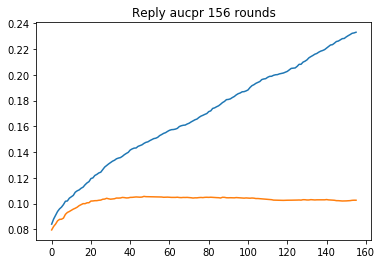

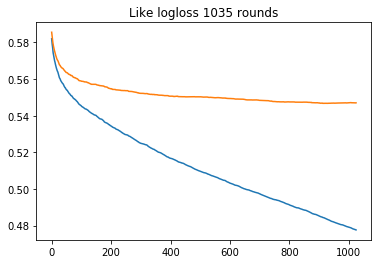

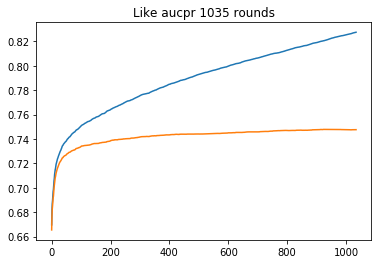

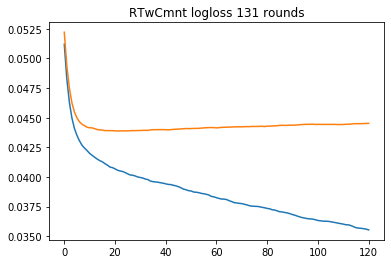

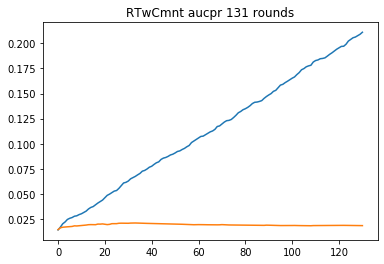

In [13]:
for tgt,res in tgt2res.items():
    evalres=res['evals_result']
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

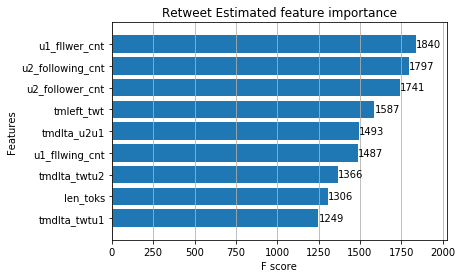

Retweet


,0,1
13,u1_fllwer_cnt,1840
10,u2_following_cnt,1797
2,u2_follower_cnt,1741
26,tmleft_twt,1587
17,tmdlta_u2u1,1493
18,u1_fllwing_cnt,1487
16,tmdlta_twtu2,1366
6,len_toks,1306
23,tmdlta_twtu1,1249
5,tmleft_u2,841


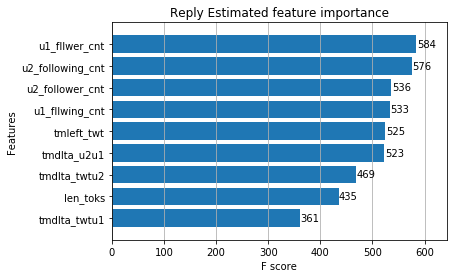

Reply


,0,1
7,u1_fllwer_cnt,584
5,u2_following_cnt,576
4,u2_follower_cnt,536
9,u1_fllwing_cnt,533
20,tmleft_twt,525
14,tmdlta_u2u1,523
3,tmdlta_twtu2,469
13,len_toks,435
17,tmdlta_twtu1,361
2,tmleft_u2,308


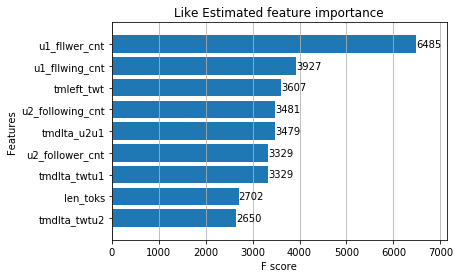

Like


,0,1
11,u1_fllwer_cnt,6485
17,u1_fllwing_cnt,3927
20,tmleft_twt,3607
6,u2_following_cnt,3481
22,tmdlta_u2u1,3479
8,tmdlta_twtu1,3329
12,u2_follower_cnt,3329
3,len_toks,2702
14,tmdlta_twtu2,2650
15,u1id_freq,1634


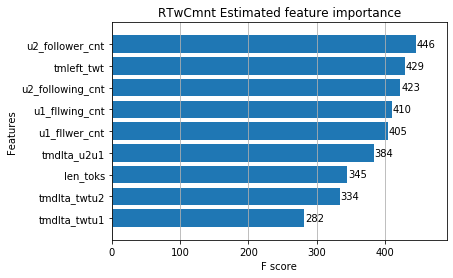

RTwCmnt


,0,1
0,u2_follower_cnt,446
15,tmleft_twt,429
16,u2_following_cnt,423
4,u1_fllwing_cnt,410
9,u1_fllwer_cnt,405
7,tmdlta_u2u1,384
19,len_toks,345
5,tmdlta_twtu2,334
10,tmdlta_twtu1,282
6,tmleft_u2,253


In [14]:
def show_feat_importance(tgt):
    bst=tgt2res[tgt]['bst']
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgts:
    show_feat_importance(tgt)

In [15]:
for tgt in tgts:
    res=tgt2res[tgt]
    print(tgt)
    prdtr, prdvl = res['prdtr'], res['prdvl']
    ytr, yvl = res['ytr'], res['yvl']
    auc_tr=compute_prauc(prdtr, ytr)
    rce_tr=compute_rce(prdtr, ytr)
    auc_vl=compute_prauc(prdvl, yvl)
    rce_vl=compute_rce(prdvl, yvl)
    res['scrs'] = {
        'auc_tr':auc_tr,
        'rce_tr':rce_tr,
        'auc_vl':auc_vl,
        'rce_vl':rce_vl,
    }    
    print('tr prauc:', f'{auc_tr:.4f}','tr rce:', f'{rce_tr:.4f}', )
    print('vl prauc:', f'{auc_vl:.4f}','vl rce:', f'{rce_vl:.4f}', )

Retweet
tr prauc: 0.4676 tr rce: 22.2144
vl prauc: 0.3549 vl rce: 14.6768
Reply
tr prauc: 0.1536 tr rce: 15.4654
vl prauc: 0.1051 vl rce: 12.0702
Like
tr prauc: 0.8214 tr rce: 29.4722
vl prauc: 0.7479 vl rce: 20.2373
RTwCmnt
tr prauc: 0.0650 tr rce: 10.3129
vl prauc: 0.0209 vl rce: 5.1630


In [16]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    res = tgt2res[tgt]
    if tgt not in tgt2res: continue
    lsttr+=[(f'PRAUC {tgt}',res['scrs']['auc_tr']),
          (f'RCE {tgt}',res['scrs']['rce_tr'])]
    lstvl+=[(f'PRAUC {tgt}',res['scrs']['auc_vl']),
          (f'RCE {tgt}',res['scrs']['rce_vl'])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.467579,22.2144,0.153602,15.4654,0.821362,29.4722,0.0650067,10.3129
scrvl,0.354916,14.6768,0.105091,12.0702,0.747921,20.2373,0.0208672,5.16303


# save results

In [17]:
pickle.dump(cols_feat, open(f"{p_out}/cols_feat.p", "wb"))
pickle.dump(tgt2res, open(f"{p_out}/tgt2res.p", "wb"))

# infer

In [18]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)


CPU times: user 8.01 ms, sys: 818 µs, total: 8.83 ms
Wall time: 7.69 ms


In [19]:
%%time
dftst = prpdf(dftst, istrn=False)

CPU times: user 70.7 ms, sys: 3.23 ms, total: 73.9 ms
Wall time: 69.7 ms


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


In [20]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2res[tgt]['bst']
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    tgt2prdtst[tgt] = prdtst

2020-03-31 22:50:17 Retweet
2020-03-31 22:50:17 Reply
2020-03-31 22:50:17 Like
2020-03-31 22:50:17 RTwCmnt
CPU times: user 542 ms, sys: 49.2 ms, total: 591 ms
Wall time: 27.4 ms


In [21]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [22]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-31 22:50:17 Retweet
2020-03-31 22:50:17 Reply
2020-03-31 22:50:17 RTwCmnt
2020-03-31 22:50:17 Like
CPU times: user 630 ms, sys: 69 ms, total: 699 ms
Wall time: 23.7 ms
